In [1]:
import json
import os
import pandas as pd    
import pprint
import shutil
import random
from PIL import Image
import sys
sys.path.append("../../")
from utils.tool import resize_image, preprocess_resize_img, view_img_size_statistics

In [2]:
default_max_l = 102400
MIN_LEN = 512
MAX_LEN = [default_max_l, 1280]#default_max_l, 1024

def clean_text(text):
    # pttns = [".net", ".co", ".com", ".c"]
    # new_word_ls = []
    # for w in text.split():
    #     wl = w.lower()
    #     if not any([wl.strip("]/*@.,!#$^()%-;: ").endswith(p) for p in pttns]):
    #         new_word_ls.append(w)
    # text = " ".join(new_word_ls)
    text = text.replace("imgflip com", "").replace("imgflip co", "").replace("imgflip", "")
    text = " ".join(text.split())
    return text
        
def preprocess_PrideMM(
    root="./",
    save_data_jsons=False, 
    include_gt_captions=False,
    use_processed_img=False,
):
    save_to = os.path.join(root, 'data')
    if not os.path.exists(save_to):
        os.makedirs(save_to)
    # root = os.path.join(root, 'src')
    image_folder_name = 'Images'
    image_path = os.path.join(root, image_folder_name)

    if use_processed_img:
        processed_image_paths = {}
        for max_l in MAX_LEN:
            p_folder = f"{image_folder_name}_{MIN_LEN}"
            if max_l < default_max_l:
                p_folder += f"_{max_l}"
            one_pp = os.path.join(root, p_folder)
            processed_image_paths[max_l] = (p_folder, one_pp)
            if not os.path.exists(one_pp):
                os.makedirs(one_pp)

    file_path = os.path.join(root, "PrideMM.csv")
    data_df = pd.read_csv(file_path)
    ori_data = json.loads(data_df.to_json(orient="records"))
    splits = ['test', 'dev', 'train'] 
    data_statistics = {sp: {'hateful':0, 'non-hateful':0} for sp in splits}
    # Record img size
    ori_sizes = {sp: {'w': {}, 'h': {}} for sp in splits}
    after_sizes = {}
    if use_processed_img:
        after_sizes = {max_l: {sp: {'w': {}, 'h': {}} for sp in splits} for max_l in MAX_LEN}

    target_map = {
        0: "undirected",
        1: "individual",
        2: "community",
        3: "organization",
    }
    stance_map = {
        0: "neutral",
        1: "support",
        2: "oppose"
    }
    all_data = {sp: [] for sp in splits}
    if include_gt_captions:
        annotations = {}
        for sp in splits:
            annotations[sp] = {}
            anno_file = os.path.join(f"./caption_annotations", f"{sp}.json")
            if os.path.exists(anno_file):
                annotations[sp] = json.load(anno_file) # a dict {"12": {'img':, 'gt_caption':}}
    
    for item in ori_data:
        sp = item.pop('split')
        label = item.pop('hate')
        target = item.pop('target')
        stance = item.pop('stance')
        item['label'] = label
        item['target'] = target_map[int(target)] if target else None
        item['stance'] = stance_map[int(stance)]
        if sp == 'val':
            sp = 'dev'
        if item['label'] == 1:
            data_statistics[sp]['hateful'] += 1
        else:
            data_statistics[sp]['non-hateful'] += 1

        img_name = item.pop('name')
        img = img_name.split("_")[1]
        item['id'] = img.split(".")[0]
        
        if include_gt_captions:
            item['gt_description'] = ""
            if annotations[sp] and (item["id"] in annotations[sp]):
                item['gt_description'] = annotations[sp][item["id"]]["gt_caption"]
        
        # -------------------- Copy and move image -------------------- #
        label_folder = str(label)
        new_split_image_path = os.path.join(image_path, sp, label_folder)
        if not os.path.exists(new_split_image_path):
            os.makedirs(new_split_image_path)
        new_img_path = os.path.join(new_split_image_path, img)
        if not os.path.exists(new_img_path):
            print("+1")
            ori_img_path = os.path.join(image_path, 'Images', img_name)
            assert os.path.exists(ori_img_path)
            shutil.copy(ori_img_path, new_img_path)
        item['img'] = os.path.join('./data/PrideMM', 'Images', sp, label_folder, img)

        # # Check image size distribution
        img = Image.open(new_img_path)
        width, height = img.size
        ori_sizes[sp]['w'][item['id']] = width
        ori_sizes[sp]['h'][item['id']] = height
        if use_processed_img:
            if sp != 'train':
                item, after_sizes = preprocess_resize_img(processed_image_paths, image_folder_name, sp, new_split_image_path, new_img_path, item, after_sizes, MIN_LEN)
        # -------------------------- move imgage -------------------------- #
        caption = item.pop('text')
        item['text'] = clean_text(caption)
        all_data[sp].append(item)
    
    if save_data_jsons:
        for sp, new_data in all_data.items():
            json.dump(new_data, open(os.path.join(save_to, f'{sp}.json'), 'w'), indent=4)
    # ------------------------img size statistics---------------------------
    tmp = {'before': ori_sizes, 'after': after_sizes}
    for sp, new_data in all_data.items():
        view_img_size_statistics(tmp, sp, len(new_data), "PrideMM")
    print(pprint.pformat(data_statistics))
    
preprocess_PrideMM(save_data_jsons=True, use_processed_img=True)

Enlarged ./Images/test/0/23.png from 423x500 to 433x512.
Enlarged ./Images/test/0/23.png from 423x500 to 433x512.
Compressed ./Images/dev/0/30.png from 1512x1080 to 1280x914.
Compressed ./Images/test/1/36.png from 1518x1440 to 1280x1214.
Enlarged ./Images/test/0/61.png from 375x500 to 384x512.
Enlarged ./Images/test/0/61.png from 375x500 to 384x512.
Compressed ./Images/test/1/113.png from 1977x1080 to 1280x699.
Enlarged ./Images/dev/1/118.png from 225x225 to 512x512.
Enlarged ./Images/dev/1/118.png from 225x225 to 512x512.
Compressed ./Images/dev/0/130.png from 1353x1080 to 1280x1021.
Compressed ./Images/test/1/154.png from 1696x1696 to 1280x1280.
Enlarged ./Images/dev/0/161.png from 498x373 to 511x383.
Enlarged ./Images/dev/0/161.png from 498x373 to 511x383.
Enlarged ./Images/test/0/174.png from 500x500 to 512x512.
Enlarged ./Images/test/0/174.png from 500x500 to 512x512.
Compressed ./Images/test/1/224.png from 1722x1080 to 1280x802.
Compressed ./Images/dev/0/233.png from 1170x2078 to

In [5]:
def pridemm_gen_annotation_sheet(source_paths):
    sep = "pridemm/"
    save_to = "./caption_annotations"
    if not os.path.exists(save_to):
        os.makedirs(save_to)
    splits = list(set([src.split(sep)[1].split("/")[0] for src in source_paths]))
    splits_save_to = {sp: os.path.join(save_to, f'{sp}.json') for sp in splits}
    #data_to_annotate = {sp: {} for sp in splits}
    data_to_annotate = {}
    for sp, path in splits_save_to.items():
        if os.path.exists(path):
            data_to_annotate[sp] = json.load(open(path))
        else:
            data_to_annotate[sp] = {}
    for src in source_paths:
        split = src.split(sep)[1].split("/")[0]
        for item in json.load(open(src)):
            if item['id'] not in data_to_annotate[split]:
                data_to_annotate[split][item['id']] = {
                    'img': item['img'],
                    'gt_caption': ''''''
                }
    for sp, data in data_to_annotate.items():
        json.dump(data, open(splits_save_to[sp], 'w'), indent=4)
        print(f"#data to be annotated in {sp}: {len(data)}")
    return

sources = [
    "/data/fengjun/projects/LLM/meme/HMC/results/pridemm/test/seed-42/qwen2.5-14bf/D6_llava1.6-7bf_len-1024_GPU-2_20250324134437/history/66.15-round-1_Decision-v1-v0/incorrect.json",
    "/data/fengjun/projects/LLM/meme/HMC/results/pridemm/test/seed-42/qwen2.5-14bf/D6_llava1.6-7bf_len-1024_GPU-2_20250324134437/history/70.3-round-1_Decision-v1-v0/incorrect.json",
    "/data/fengjun/projects/LLM/meme/HMC/results/pridemm/test/seed-42/qwen2.5-14bf/D6_llava1.6-7bf_len-1024_GPU-2_20250324134437/history/round-5_Decision-v1-v0/incorrect.json",
    "/data/fengjun/projects/LLM/meme/HMC/results/pridemm/test/seed-42/qwen2.5-14bf/D6_llava1.6-7bf_len-1024_GPU-2_20250324134437/history/new-knowledge_round-1_Decision-v1-v0/incorrect.json",
    "/data/fengjun/projects/LLM/meme/HMC/results/pridemm/test/seed-42/qwen2.5-14bf/D6_llava1.6-7bf_len-1024_GPU-2_20250324134437/history/worse-round-1_Decision-v1-v0/incorrect.json"
]
pridemm_gen_annotation_sheet(sources)

#data to be annotated in test: 319


## Image Viewer

In [5]:
import json
from IPython.display import Image as IPythonImage
from IPython.display import display

A total of 11 images with label=1.
Divided into 1 groups, the last group has 11 images.
1367


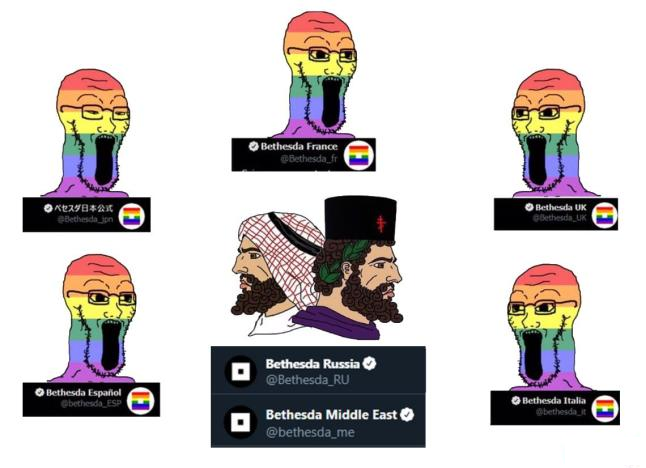

1516


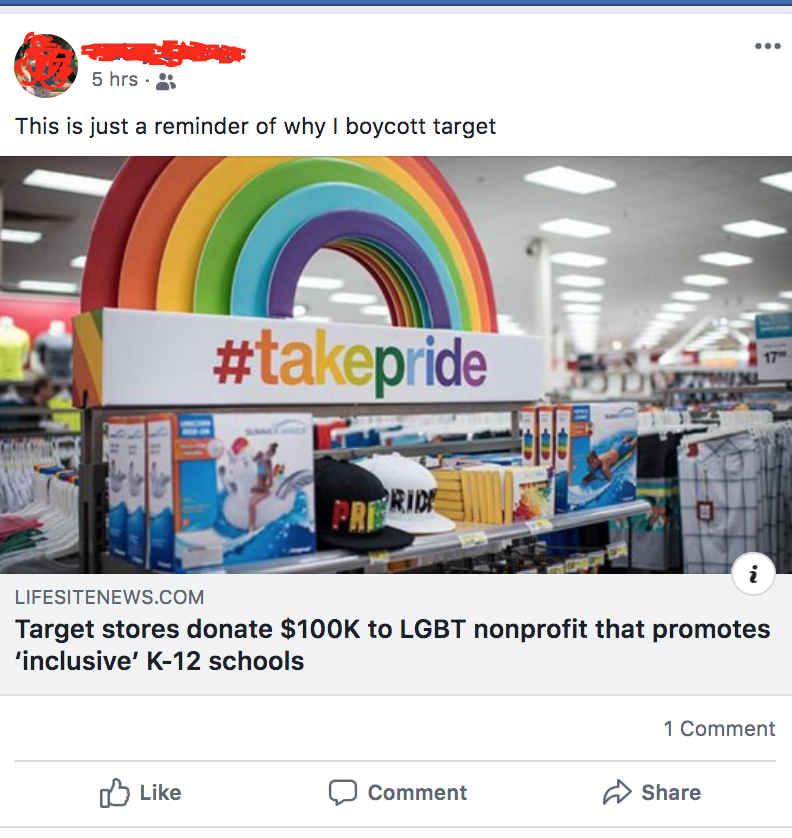

1708


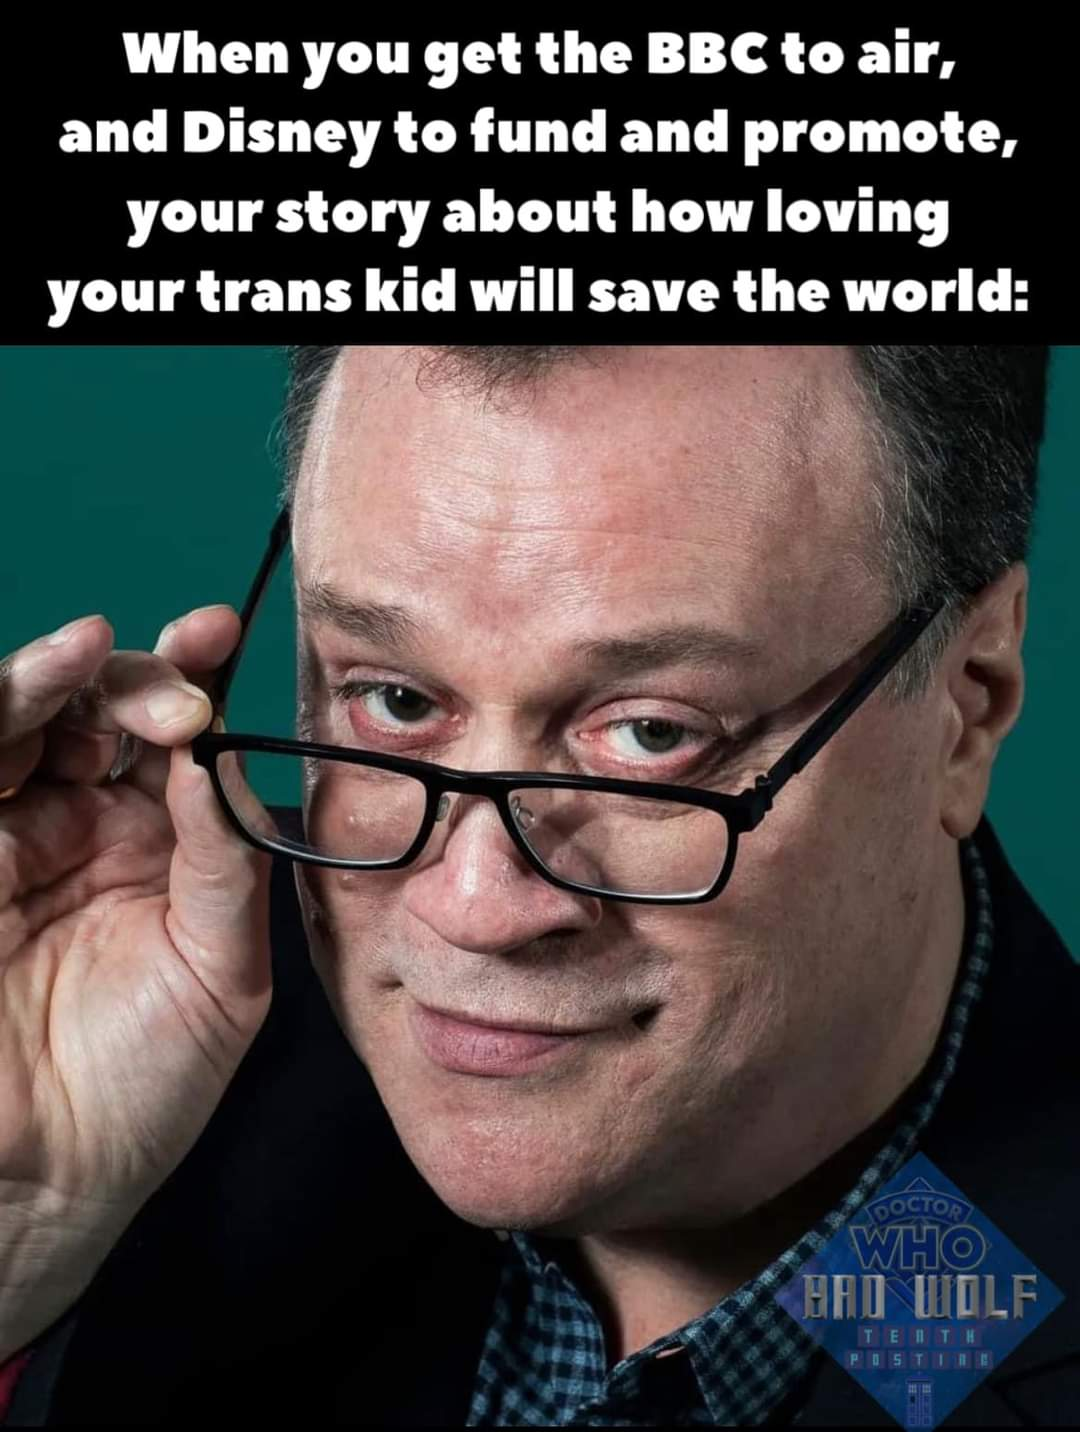

2005


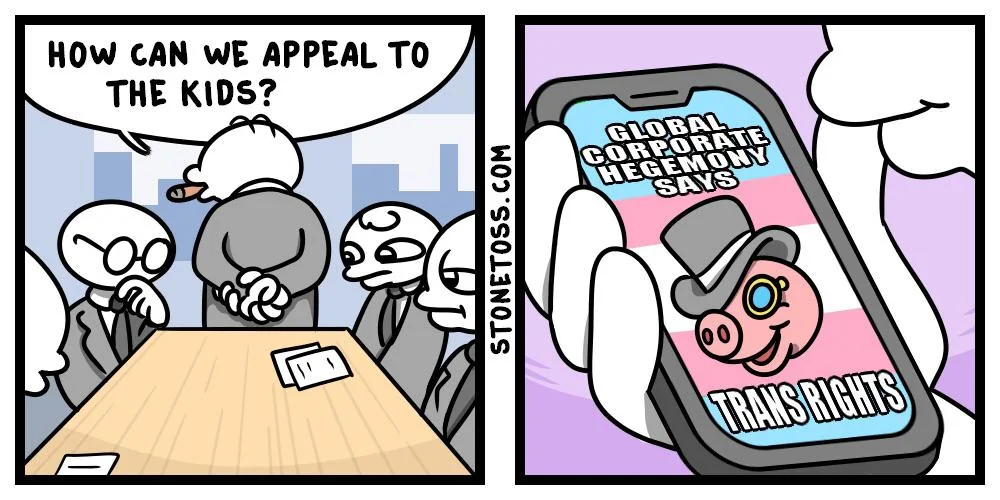

2662


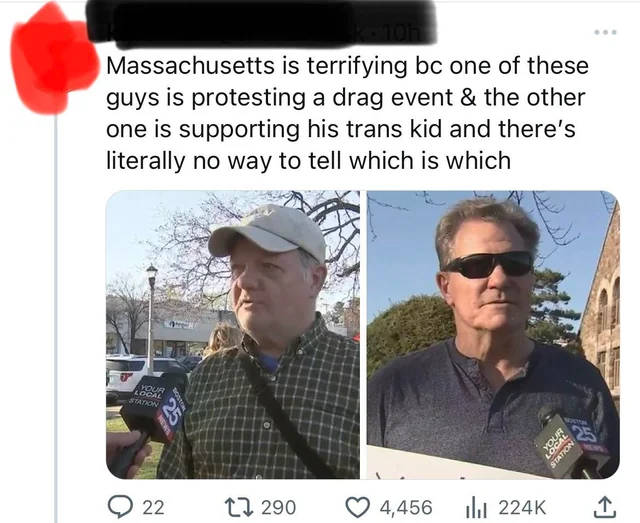

2811


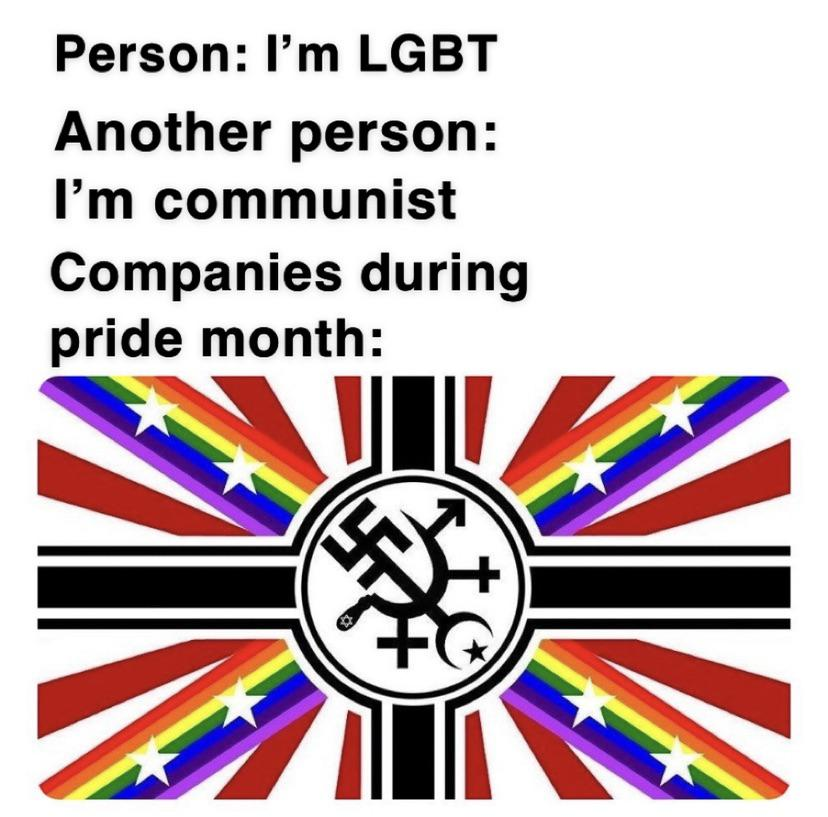

2938


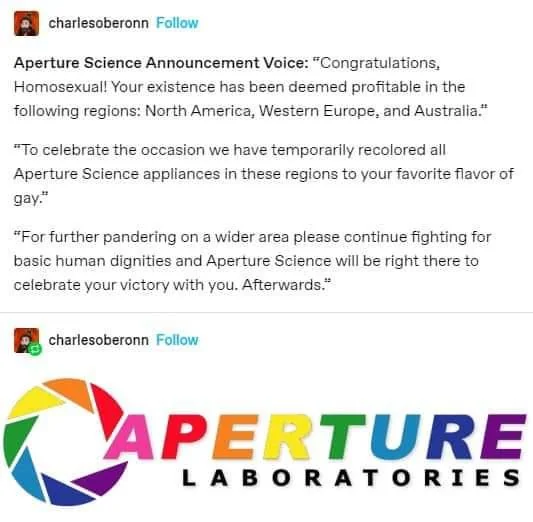

4212


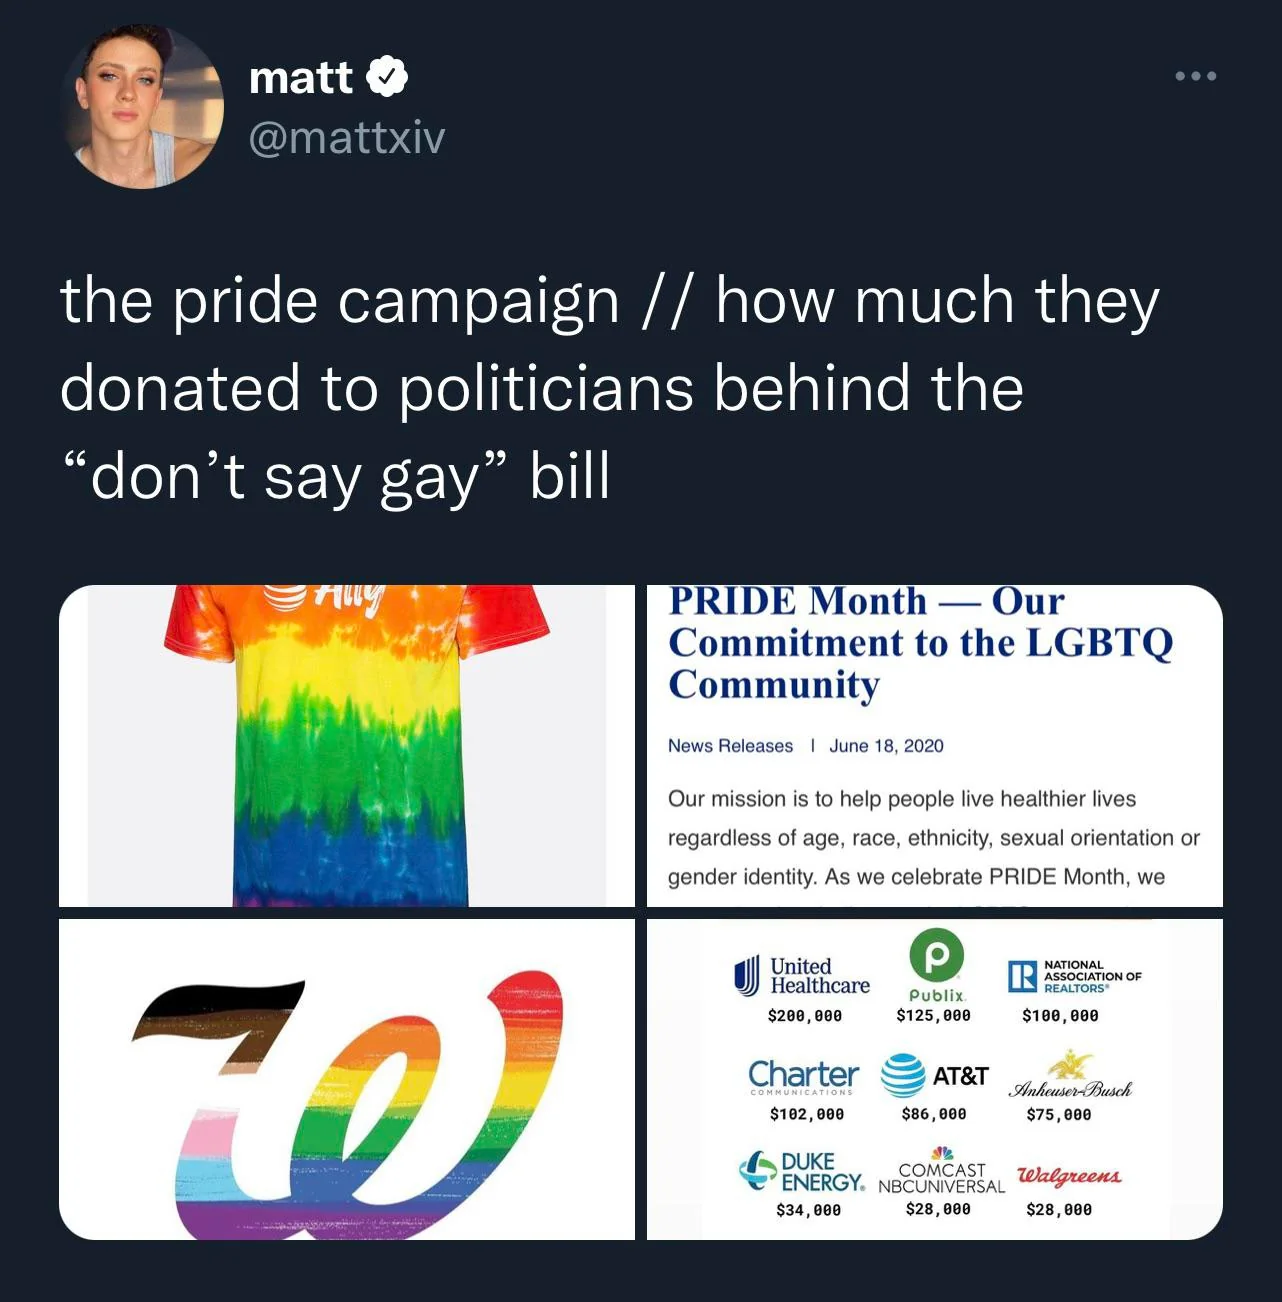

4364


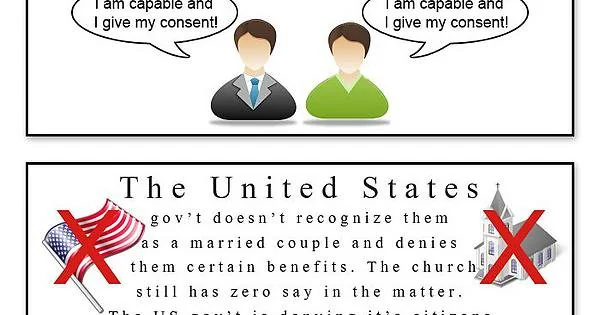

4580


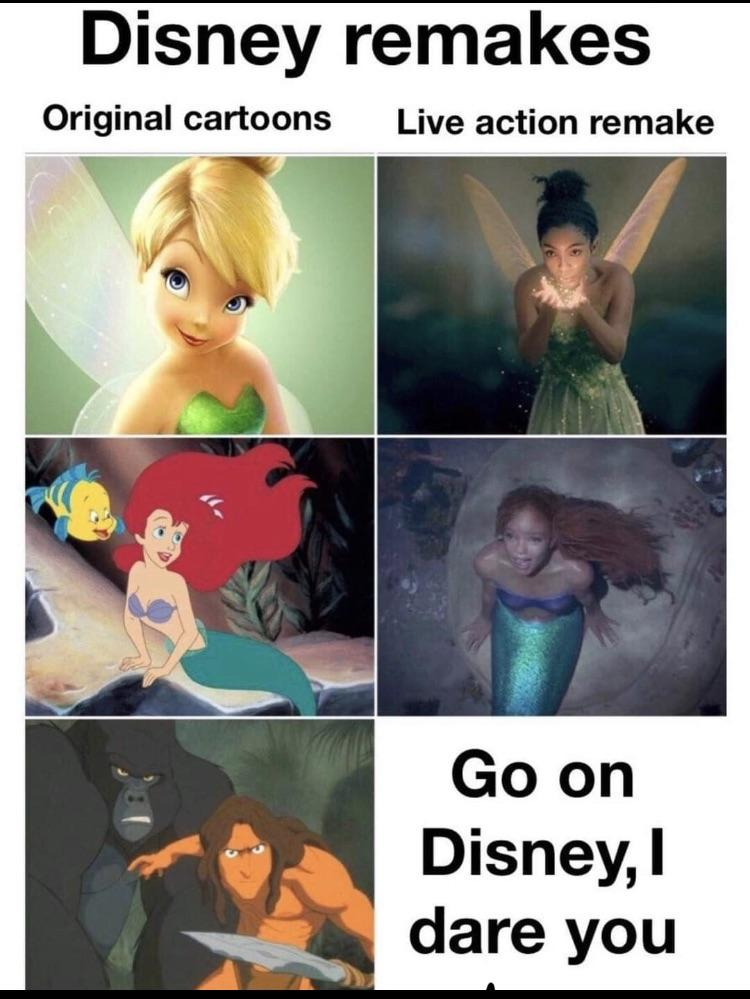

4600


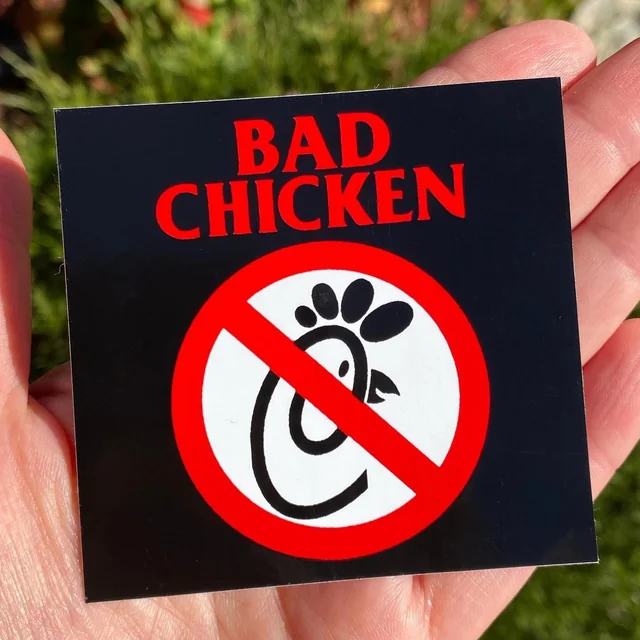

In [7]:

def view_imgs(split, target=None, positive=True):
    target_label = 0
    if positive:
        target_label = 1
    
    target_file = f"./data/{split}.json"
    img_folder = f"./Images/{split}/{target_label}"
    count = 0
    all_imgs = []
    one_group = []
    data = json.load(open(target_file))
    for item in data:
        cont = item['label'] == target_label if target is None else (item['label'] == target_label) and (item['target'] == target)
        if cont:
            count += 1
            one_group.append({'id': item['id'], 'img': os.path.join(img_folder, item['img'].split("/")[-1])})
            if (count % 20) == 0:
                all_imgs.append(one_group)
                one_group = []
    all_imgs.append(one_group)
    print(f"A total of {count} images with label={target_label}.\nDivided into {len(all_imgs)} groups, the last group has {len(all_imgs[-1])} images.")
    return all_imgs

split = 'dev'
img_groups = view_imgs(split, target="organization")
if img_groups:
    group_id = 0
    for img in img_groups[group_id]:
        print(img['id'])
        display(IPythonImage(filename=img['img']))